In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pandas_ta as ta

In [2]:
from get_ticker import get_ccxt_data



CONNECT : eth_ethusdt


In [3]:
df_eth_raw = get_ccxt_data('ETHUSDT', tf= '1m').set_index('timestamp')
df_bnb_raw = get_ccxt_data('BNBUSDT', tf= '1m').set_index('timestamp')


In [85]:
df_eth = df_eth_raw.copy()
df_bnb = df_bnb_raw.copy()

In [186]:
def process_data(df, prefix= ''):
    df[prefix+'_rsi_indi'] = df.ta.rsi(length= 14) > 50
    # df['obv'] = df.ta.obv()
    # df['obv_ma_f'] = ta.ema(df['obv'], 20)
    df[prefix+'_vol_indi'] = ta.ema(df.ta.obv(), 20) > ta.ema(df.ta.obv(), 40)

    if prefix == 'eth':
        df[prefix+'_price_chg'] = (df['close'] - df['close'].shift(-1)) / df['close'].shift(-1)
        df[prefix+'_profit'] = df[prefix+'_price_chg'] > 0 
        df = df[['open','high', 'low' ,prefix+'_rsi_indi', prefix+'_vol_indi', prefix+'_profit']]
    else:
        df[prefix+'_price_chg'] = (df['close'] - df['close'].shift(-1)) / df['close'].shift(1)
        df[prefix+'_price_up'] = df[prefix+'_price_chg'] > 0 
        df = df[[prefix+'_rsi_indi', prefix+'_vol_indi', prefix+'_price_up']]
    df_result  = df.dropna()
    return df_result


In [173]:
df_eth = df_eth_raw.copy()
df_bnb = df_bnb_raw.copy()

df_bnb = process_data(df_bnb, 'bnb')
df_eth = process_data(df_eth, 'eth')
df = df_bnb.join(df_eth)
df.head()

,bnb_rsi_indi,bnb_vol_indi,bnb_price_up,open,high,low,eth_rsi_indi,eth_vol_indi,eth_profit
timestamp,,,,,,,,,
2024-01-06 03:59:00,False,False,False,2247.61,2249.60,2245.82,False,False,True
2024-01-06 04:00:00,False,False,False,2248.36,2248.74,2245.00,False,False,False
2024-01-06 04:01:00,False,False,True,2245.01,2246.00,2243.60,False,False,True
2024-01-06 04:02:00,False,False,True,2245.65,2246.19,2241.07,False,False,True
2024-01-06 04:03:00,False,False,False,2242.16,2242.62,2240.28,False,False,True


In [108]:
print('total Y == True :',len(df.loc[df['eth_profit'] == 1]))
print('total Y == False :',len(df.loc[df['eth_profit'] == 0]))

total Y == True : 502
total Y == False : 498


In [119]:
df_ml = df.copy()
df_ml = df_ml.dropna()

In [111]:
df_ml = df_ml.dropna()

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

In [120]:
df_ml = df.copy()
df_ml = df_ml.dropna()

y = df_ml.pop('eth_profit')
X = df_ml


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 44)

In [136]:
rf = RandomForestClassifier(n_estimators= 100, max_depth= 6, random_state= 14)

In [137]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=14)

In [138]:
y_pred = rf.predict(X_test)

In [159]:
cm_result = confusion_matrix(y_test, y_pred)
print('CONFUSION METRIC :\n',cm_result)

CONFUSION METRIC :
 [[74 25]
 [35 66]]


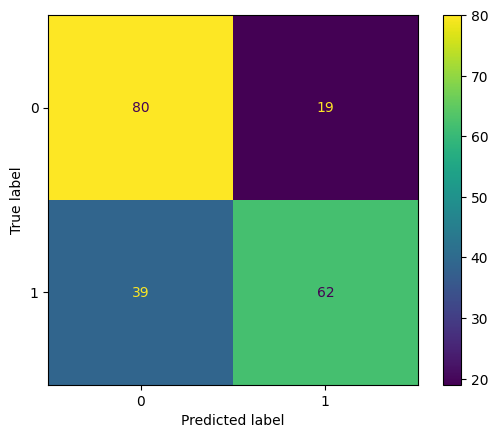

In [134]:
disp = ConfusionMatrixDisplay(cm_result)
disp.plot()
plt.show()

In [143]:
f1 = f1_score(y_test, y_pred)
prcision = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [147]:
print('F1 Score :', f1)
print(f'Precision Score :{prcision:.6f}', )
print(f'Accuracy Score :{acc:.6f}')
print(f'Recall Score :{recall:.6f}')

F1 Score : 0.6875
Precision Score :0.725275
Accuracy Score :0.700000
Recall Score :0.653465


In [232]:
def get_new_data_and_pred( model= rf):
    # global get_ccxt_data
    _df_eth = get_ccxt_data('ETHUSDT', tf= '1m', limit=42).set_index('timestamp')
    _df_bnb = get_ccxt_data('BNBUSDT', tf= '1m', limit= 42).set_index('timestamp')
    _df_bnb = process_data(_df_bnb, 'bnb')
    _df_eth = process_data(_df_eth, 'eth')
    _df = _df_bnb.join(_df_eth)
    _df = _df.iloc[-1:, :].drop(['eth_profit'], axis= 1)
    new_data = list(_df.values)
    result = model.predict(new_data)
    return result[0]
        


In [233]:
result = get_new_data_and_pred()
result

e:\DADS\DADS6005_Realtime_Analytics\realtime-ml-kafka-crypto\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


False

In [225]:
# new_data = [[True, False, False,	2259.72,2259.73, 2259.20, True, True]]
# new_list = df_new
# ret=rf.predict(new_list)

e:\DADS\DADS6005_Realtime_Analytics\realtime-ml-kafka-crypto\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [1]:
from datetime import datetime as dt

In [5]:
_now = dt.now()
_now.minute

In [10]:
c = 61
c % 60 

1